# Figure 5

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
from tqdm import tqdm
import multiprocessing as mp
import re
import pickle

sys.path.append('./utils/')
from odeAnalysisUtils import GenerateATComparisonPlot
import LotkaVolterraModel as lvm
import myUtils as utils
from fittingUtils import PatientToOutcomeMap, LoadPatientData, LoadFit, GetBestFit, PlotFits, \
            GenerateFitSummaryDf_AllPatients, visualize_scatter_with_images, PlotParameterDistribution_PatientCohort

# Format plots
sns.set(style="white",
        font_scale=1.5,
        rc={'figure.figsize':(12,6)})

In [2]:
dataDir = "./data/clinicalData/Bruchovsky_et_al/"
patientList = [int(re.findall(r'\d+',x)[0]) for x in os.listdir(dataDir)]
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'max_step':50, 'suppressOutputB':False}

# Make directory for figures
if not os.path.isdir("./figures/"):
    os.mkdir("./figures/")

**Note:** Fitting takes several hours. The script to run the fitting algorithm can be found in `fitPatients.py`. The fits obtained by running the above script, which are shown in the paper are included in this repository in `data/fits`. The patient data itself can be found in `data/clinicalData`. 

In [3]:
fitDir = "./data/fits/4params/"
patientsToExcludeList = [32, 46, 64, 83, 92] + [3,19,50,52,77,95,101,105,6,104,13,11,58,91,87] # patients excluded because they developed a metastasis or due to poor fits
fitSummaryDf = pd.read_csv(os.path.join(fitDir,"fitSummaryDf.csv"),index_col=0)
dataToAnalyse = fitSummaryDf[np.isin(fitSummaryDf.PatientId,patientsToExcludeList)==False].copy()

# For patient 84 the AIC of a degenerate fit is better than a more realistic alternative fit. Use the more 
# realistic fit instead of the 'theoretically' better one
fit = LoadFit(fitId=12,patientId=84,fitDir=fitDir)
tmpDf = pd.DataFrame([{"PatientId": fit.patientId, "FitId": fit.fitId, 
                       "AIC": fit.aic, "BIC": fit.bic, "RSquared": fit.rSq, 
                       **fit.params.valuesdict()}])
for colName in tmpDf.columns:
    dataToAnalyse.loc[dataToAnalyse.PatientId==84,colName] = tmpDf[colName].values[0]

## a) Example fits

P26;TTP=2207.00;R2=0.74
P99;TTP=1324.00;R2=0.90


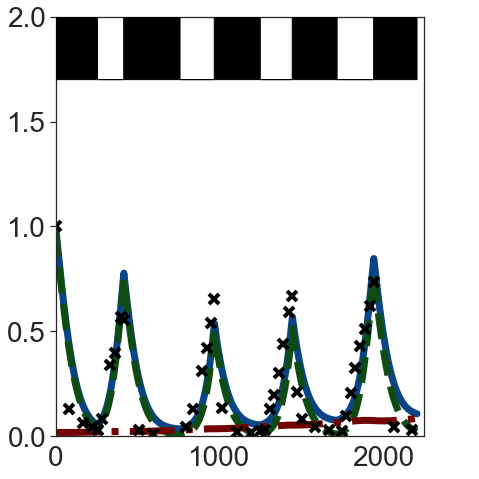

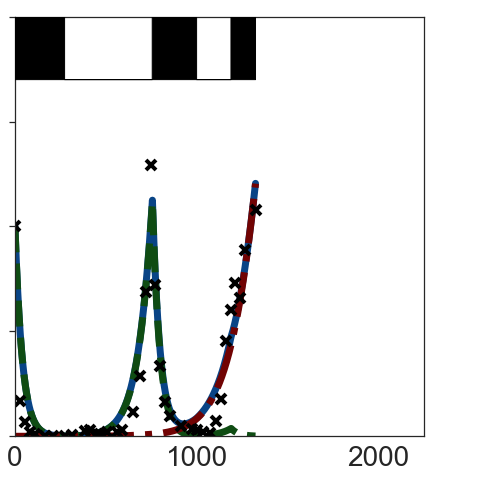

In [7]:
fitDir = "./data/fits/4params/"

for patientId in [26,99]:
    fit = GetBestFit(patientId,fitDir=fitDir)
    currDataDf = LoadPatientData(patientId,dataDir=dataDir)
    PlotFits(fits=[fit.fitId],dataDf=currDataDf,fitDir=fitDir, decorateY=patientId==26,
             xlim=2250, ylim=2., figsize=(7,7), outName="./figures/exampleFit_p%d.pdf"%patientId)
    print("P%d;TTP=%1.2f;R2=%1.2f"%(patientId,currDataDf.Time.max(),fit.rSq))    

## b) Box plot of AIC of model fitting with and without turnover and cost

In [18]:
modelList = ["4params","3params_noCost","3params_noTurnover","2params_noCost_noTurnover"]

tmpDfList = []
for model in modelList:
    tmpDf = pd.read_csv(os.path.join("./data/fits/",model,"fitSummaryDf.csv"),index_col=0)
    tmpDf['Model'] = model
    tmpDfList.append(tmpDf)
modelComparisonDf = pd.concat(tmpDfList)
modelComparisonDf = modelComparisonDf[np.isin(modelComparisonDf.PatientId,patientsToExcludeList)==False]
# modelComparisonDf.loc[(modelComparisonDf.Model=="3params_noCost") & (modelComparisonDf.PatientId==54),'AIC'] = np.nan

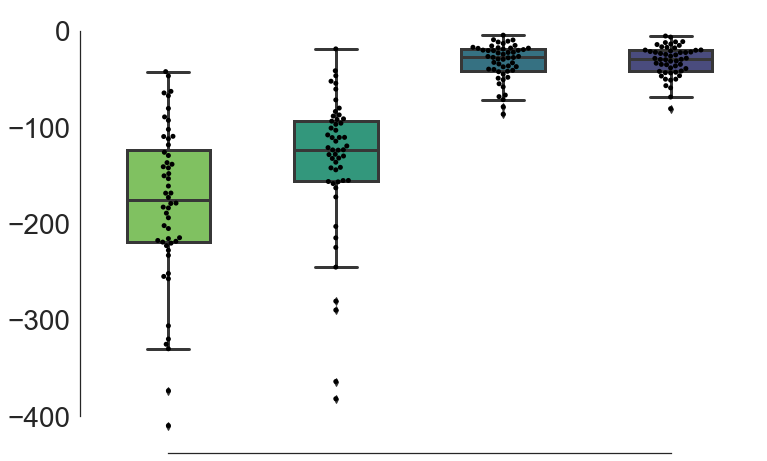

In [19]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(x="Model",y="AIC",width=0.5,palette='viridis_r',color='white',linewidth=3,data=modelComparisonDf)
sns.swarmplot(x="Model",y="AIC",color='black',data=modelComparisonDf)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.tick_params(labelsize=28)
sns.despine(ax=ax,offset=5, trim=True)
plt.savefig("./figures/fitComparisonBoxPlot.pdf")

In [10]:
from scipy import stats

for model in modelList[1:]:
    print(model)
    print(stats.ttest_rel(modelComparisonDf.AIC[modelComparisonDf.Model=='4params'],
                          modelComparisonDf.AIC[modelComparisonDf.Model==model],nan_policy='omit'))

3params_noCost
Ttest_relResult(statistic=-9.453682727494185, pvalue=8.450497115411322e-13)
3params_noTurnover
Ttest_relResult(statistic=-12.88894638923159, pvalue=1.1445213316594043e-17)
2params_noCost_noTurnover
Ttest_relResult(statistic=-13.349190714773368, pvalue=2.856850827256656e-18)


## c) Visualising the parameter space

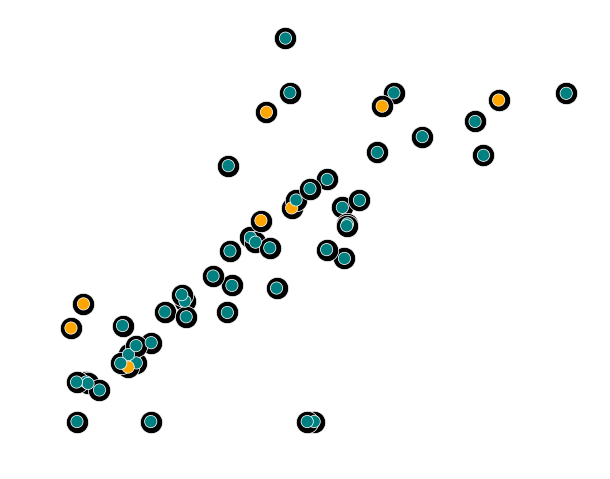

In [22]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
sns.scatterplot(x="turnover",y="cost",color='black',marker='o',s=500, #1.25e3,
                data=dataToAnalyse)#[dataToAnalyse.Progression==1])
sns.scatterplot(x="turnover",y="cost",hue="Progression",marker='o',s=150, #500,
                palette={0:"teal",1:"orange"},data=dataToAnalyse)#[dataToAnalyse.Progression==1])
ax.set_xlabel("")
ax.set_ylabel("")
ax.invert_yaxis()
ax.axis('off')
ax.legend().remove()
# ax.xaxis.set_ticks_position('top')
# ax.xaxis.set_label_position('top')
# ax.tick_params(labelsize=28)
# sns.despine(ax=ax, offset=5, trim=True, top=False, bottom=True)

plt.savefig("./figures/paramSpacePlot.pdf")

In [15]:
# Pearson correlation test in text
from scipy.stats import pearsonr
pearsonr(x=dataToAnalyse["turnover"],y=dataToAnalyse['cost'])

(-0.7662713533766032, 3.5846132953472985e-11)

In [17]:
# Comparison of parameter values between progressors and non-progressors
from scipy import stats
paramList = ["cost","turnover","n0","fR"]
for param in paramList:
    print(param,stats.mannwhitneyu(dataToAnalyse.loc[dataToAnalyse.Progression==0,param],
                    dataToAnalyse.loc[dataToAnalyse.Progression==1,param]))

cost MannwhitneyuResult(statistic=134.0, pvalue=0.14626041793796923)
turnover MannwhitneyuResult(statistic=164.0, pvalue=0.38527270064830615)
n0 MannwhitneyuResult(statistic=104.5, pvalue=0.03585744825113283)
fR MannwhitneyuResult(statistic=121.0, pvalue=0.08336116737089638)


MannwhitneyuResult(statistic=82.0, pvalue=0.008861971867955567)

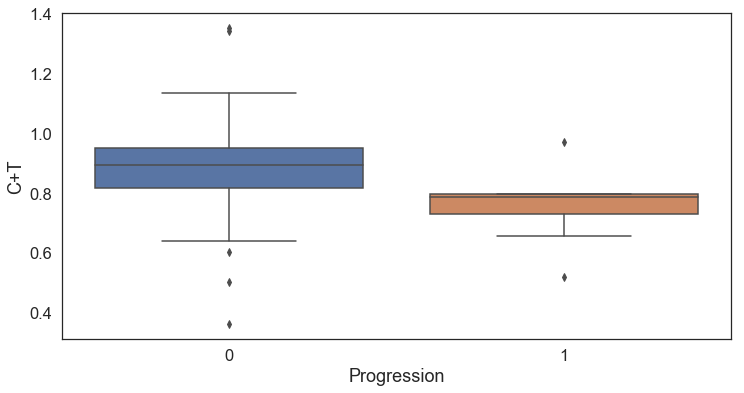

In [21]:
# Comparison of C+T score to show that combination is predictive
dataToAnalyse['C+T'] = dataToAnalyse.cost+dataToAnalyse.turnover#/(1-dataToAnalyse.turnover)

sns.boxplot(x="Progression",y="C+T",data=dataToAnalyse)
param = "C+T"
stats.mannwhitneyu(dataToAnalyse.loc[dataToAnalyse.Progression==0,param],
                dataToAnalyse.loc[dataToAnalyse.Progression==1,param])

(-0.03801207689017194, 0.789051623464908)

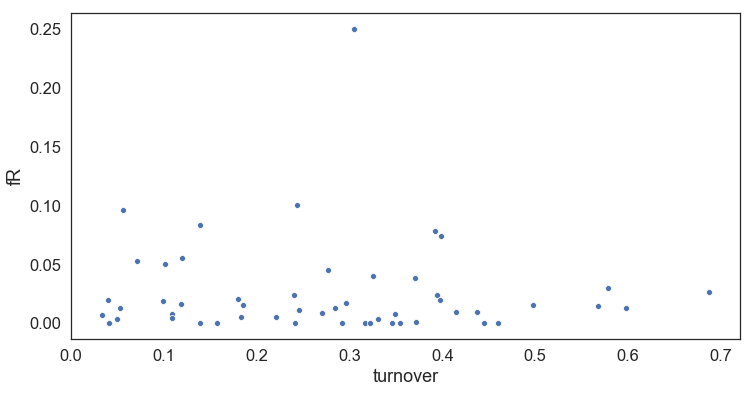

In [22]:
# Test for correlation between fR and turnover to explain why higher turnover is not associated with better outcome in these data
sns.scatterplot(x="turnover",y="fR",data=dataToAnalyse)
import scipy.stats

scipy.stats.pearsonr(x=dataToAnalyse.turnover,y=dataToAnalyse.fR)

## d) Example fits from different points in the parameter space

In [16]:
fitDir = "./data/fits/4params/"
patientsToPlotList = [12,36,75,55,56,16,85,58,14,41,31,108]
patientsToPlotXLabel = [55,14,108]
for patientId in tqdm(patientsToPlotList):
    fit = GetBestFit(patientId,fitDir=fitDir)
    PlotFits([fit],dataDf=LoadPatientData(patientId,dataDir=dataDir),
             solver_kws=solver_kws, decorateX=np.isin(patientId,patientsToPlotXLabel),
             xlim=2250,ylim=2.,linewidth=15,markersize=20,axisLabels=False,labelsize=40,figsize=(10, 8),
             outName="./figures/exampleFit_p%d.pdf"%patientId)
    plt.close()

100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


## e) Modifying treatment

In [6]:
patientId = 99
fitDir = "./data/fits/4params/"
fit = GetBestFit(patientId,fitDir=fitDir)

TTP_CT: 1293.17; TTP_AT: 1325.30
Relative gain: 2.48%; Absolute Gain: 32.13d


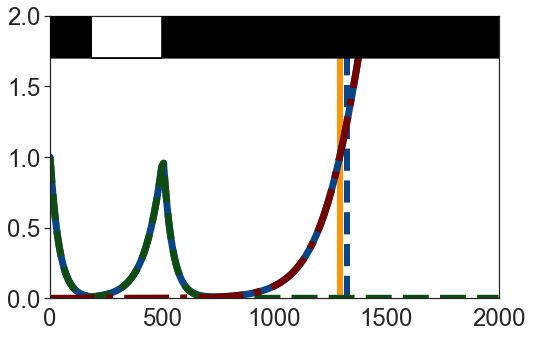

In [13]:
paramDic = fit.params.valuesdict()
paramDic['cSR'], paramDic['cRS'] = (1,1)
GenerateATComparisonPlot(initialTumourSize=paramDic['n0'],rFrac=paramDic['fR'],atThreshold=0.99,
                         markInitialSize=False,
                         normaliseToStartingValue=True,
                         paramDic=paramDic,relToPopEq=False,
                         printDifferenceInTTP=True,
                         t_end=2e3,ylim=2.,nTimePts=250,outName='./figures/improveTxExample_baseCase.pdf')

TTP_CT: 1293.17; TTP_AT: 1502.01
Relative gain: 16.15%; Absolute Gain: 208.84d


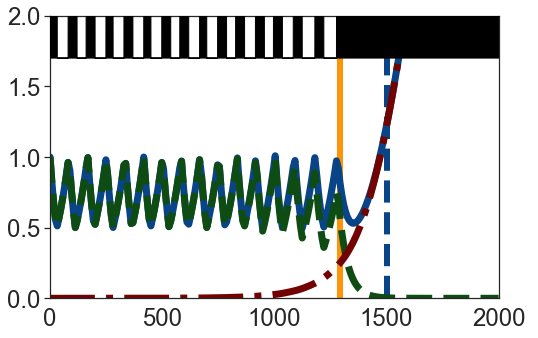

In [16]:
paramDic = fit.params.valuesdict()
paramDic['cSR'], paramDic['cRS'] = (1,1)
GenerateATComparisonPlot(initialTumourSize=paramDic['n0'],rFrac=paramDic['fR'],atThreshold=0.5,
                         markInitialSize=False,
                         normaliseToStartingValue=True,
                         paramDic=paramDic,relToPopEq=False,
                         printDifferenceInTTP=True,
                         t_end=2e3,ylim=2.,nTimePts=250,outName='./figures/improveTxExample_smallerThreshold.pdf')

TTP_CT: 1357.43; TTP_AT: 1469.88
Relative gain: 8.28%; Absolute Gain: 112.45d


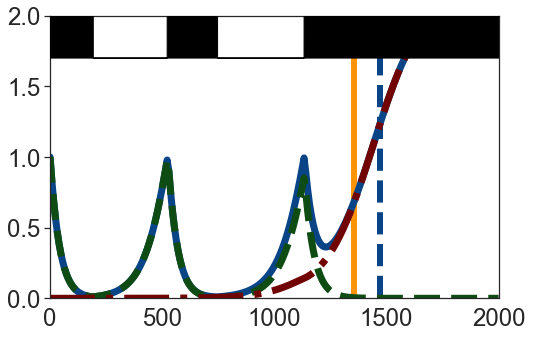

In [18]:
paramDic = fit.params.valuesdict()
paramDic['cSR'], paramDic['cRS'] = (1,1)
GenerateATComparisonPlot(initialTumourSize=paramDic['n0']*2,rFrac=paramDic['fR'],atThreshold=0.99,
                         markInitialSize=False,
                         normaliseToStartingValue=True,
                         paramDic=paramDic,relToPopEq=False,
                         printDifferenceInTTP=True,
                         t_end=2e3,ylim=2.,nTimePts=250,outName='./figures/improveTxExample_changingK.pdf')

TTP_CT: 1775.10; TTP_AT: 1847.39
Relative gain: 4.07%; Absolute Gain: 72.29d


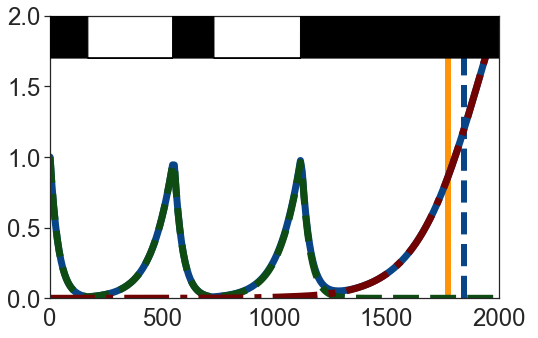

In [26]:
paramDic = fit.params.valuesdict()
paramDic['cSR'], paramDic['cRS'] = (1,1)
paramDic['dS'] *= 1.2
paramDic['dR'] *= 1.2
GenerateATComparisonPlot(initialTumourSize=paramDic['n0'],rFrac=paramDic['fR'],atThreshold=0.99,
                         markInitialSize=False,
                         normaliseToStartingValue=True,                         
                         paramDic=paramDic,relToPopEq=False,
                         printDifferenceInTTP=True,
                         t_end=2.e3,ylim=2.,nTimePts=250,outName='./figures/improveTxExample_increaseTurnover.pdf')